In [94]:
import warnings
warnings.filterwarnings("ignore")
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import nltk
from nltk.corpus import stopwords

from plotly import graph_objs as go
# import plotly.express as px
# import plotly.figure_factory as ff
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from palettable.colorbrewer.qualitative import Pastel1_7

from gensim.models import word2vec
from nltk.tokenize import word_tokenize

#%%
train = pd.read_csv('/Users/lifangwen/Documents/GitHub/PHBS_AI_TweetSentimentExtraction/01 data/train.csv')
test = pd.read_csv('/Users/lifangwen/Documents/GitHub/PHBS_AI_TweetSentimentExtraction/01 data/test.csv')
ss = pd.read_csv('/Users/lifangwen/Documents/GitHub/PHBS_AI_TweetSentimentExtraction/01 data/sample_submission.csv')

In [95]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [96]:
train.info()
train.dropna(inplace=True) #drop one nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [97]:
test.info()
#%%EDA
train.head()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 82.9+ KB


,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,595685ba72,IM SORRRYY i went to the cinema with my brot...,good,neutral
freq,1,1,199,11117


In [98]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Text(0.5, 1.0, 'The distrubution of tweets in the train set')

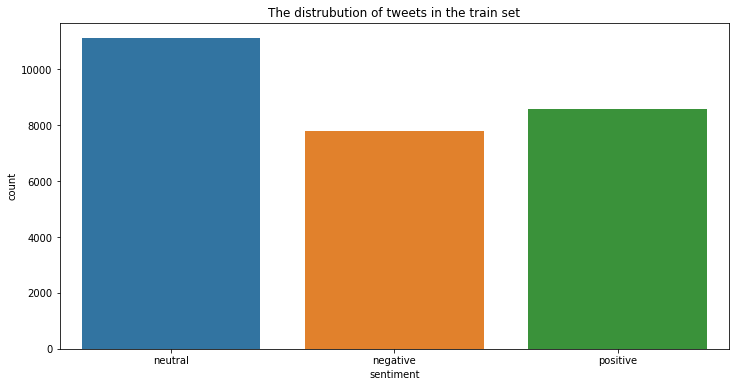

In [99]:
#the distrubution of tweets in the train set
countDistribution = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)
plt.title('The distrubution of tweets in the train set')

In [100]:
#%%see the correlation of two sentenses
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = str(row.text)
    sentence2 = str(row.selected_text)
    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])

train = train.merge(jaccard,how='outer')

train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


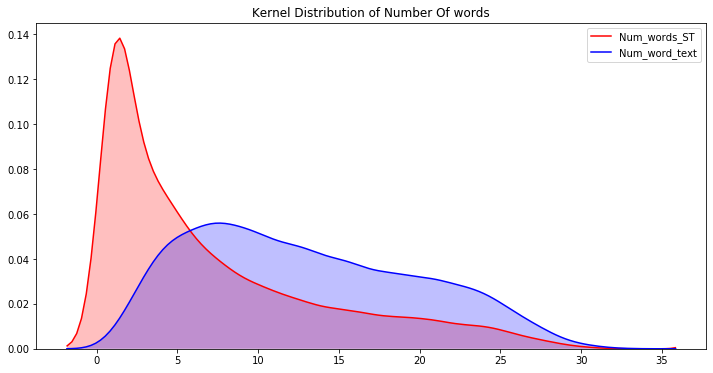

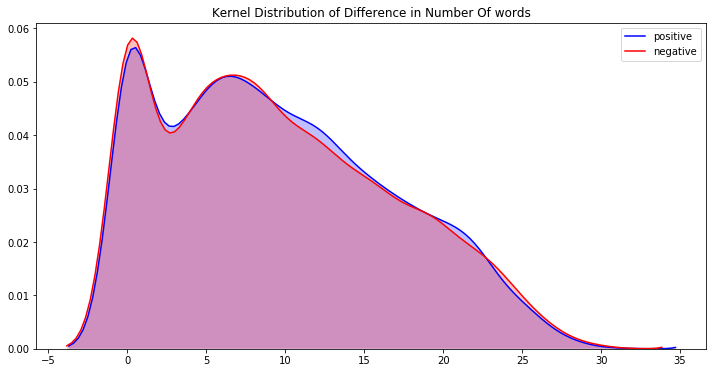

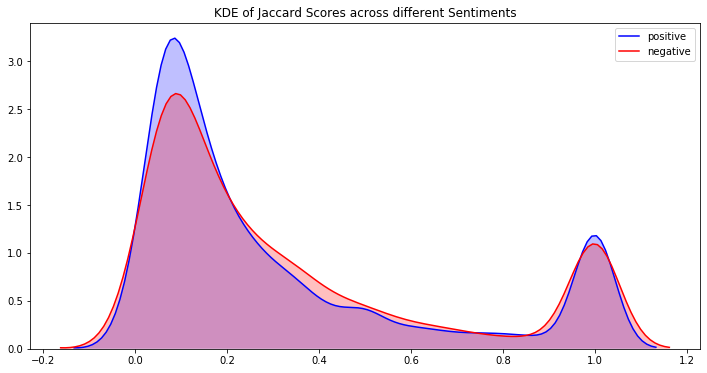

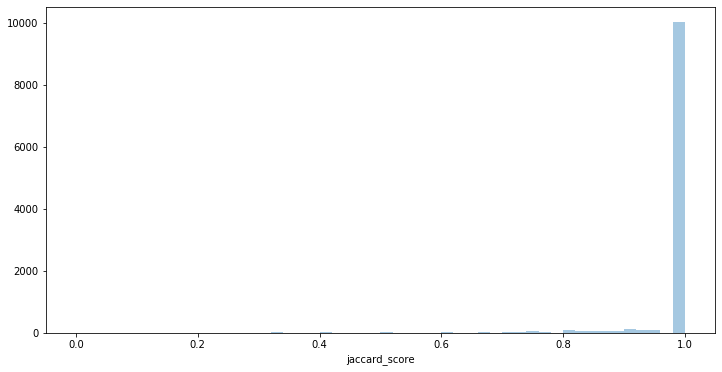

In [101]:
#%%the distribution of Meta-Features
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")
plt.show()

plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")
plt.legend(labels=['positive','negative'])
plt.show()

plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])
plt.show()

plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)
plt.show()

In [102]:
k = train[train['Num_word_text']<=2]
k.groupby('sentiment').mean()['jaccard_score']
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.000000,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.000000,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.000000,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.000000,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.000000,1,1,0
443,641db1b766,Morning tweeple,Morning tweeple,positive,1.000000,2,2,0
544,1689a46690,sweet dreams,sweet dreams,positive,1.000000,2,2,0
915,c16a52d2a7,nice clutch,nice,positive,0.500000,1,2,1
976,6c7f3f8a21,Welcome,Welcome,positive,1.000000,1,1,0
982,7411938f57,I sorry,I sorry,positive,1.000000,2,2,0


In [103]:
#%%clean the corpus
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

train.head()

#%%most common words in our train data
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x)) #run this line is really too slow

top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']

The top 20 unique words in Positive Tweets are:
              words  count
0   congratulations     26
1              thnx      8
2               lov      8
3              happ      7
4          talented      7
5         brilliant      7
6       appreciated      6
7             goood      6
8            amazin      5
9            mommas      5
10          coolest      5
11              owe      5
12        blessings      4
13       mothersday      4
14           dayyyy      4
15       refreshing      4
16         goodluck      4
17         funniest      4
18          honored      4
19            amazi      3


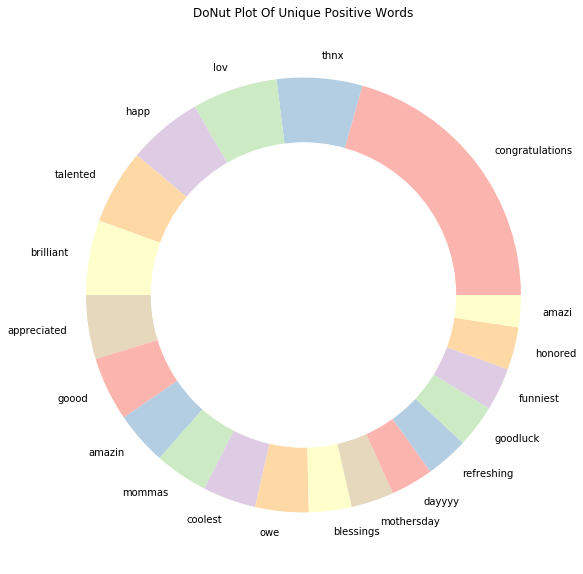

The top 10 unique words in Negative Tweets are:
        words  count
0        ache     10
1     saddest      7
2       hated      6
3        weak      6
4   suffering      6
5         rly      5
6  devastated      5
7     pissing      5
8    allergic      4
9      cramps      4


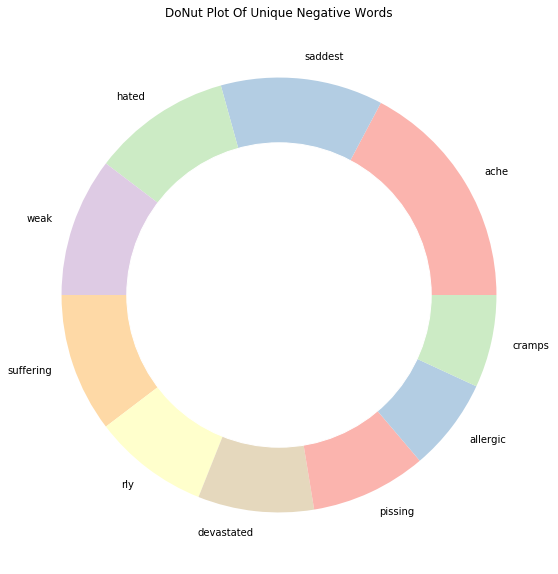

The top 10 unique words in Neutral Tweets are:
      words  count
0      hows     33
1     store     28
2    guitar     26
3     green     22
4  catching     16
5   myspace     16
6  planning     15
7    random     15
8       hrs     15
9      shop     15


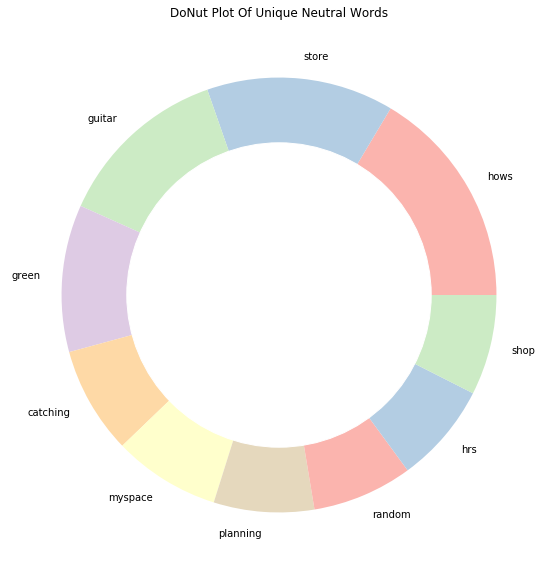

In [104]:
#%% most common words Sentiments Wise
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']

#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']

#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']

#%% N-gram analysis

#Unique Words in each Segment
raw_text = [word for word_list in train['temp_list'] for word in word_list]

def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

#%%
Unique_Positive= words_unique('positive', 20, raw_text) #really slow to run this line
print("The top 20 unique words in Positive Tweets are:")
print(Unique_Positive)

plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
print(Unique_Negative)

plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
print(Unique_Neutral)

plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

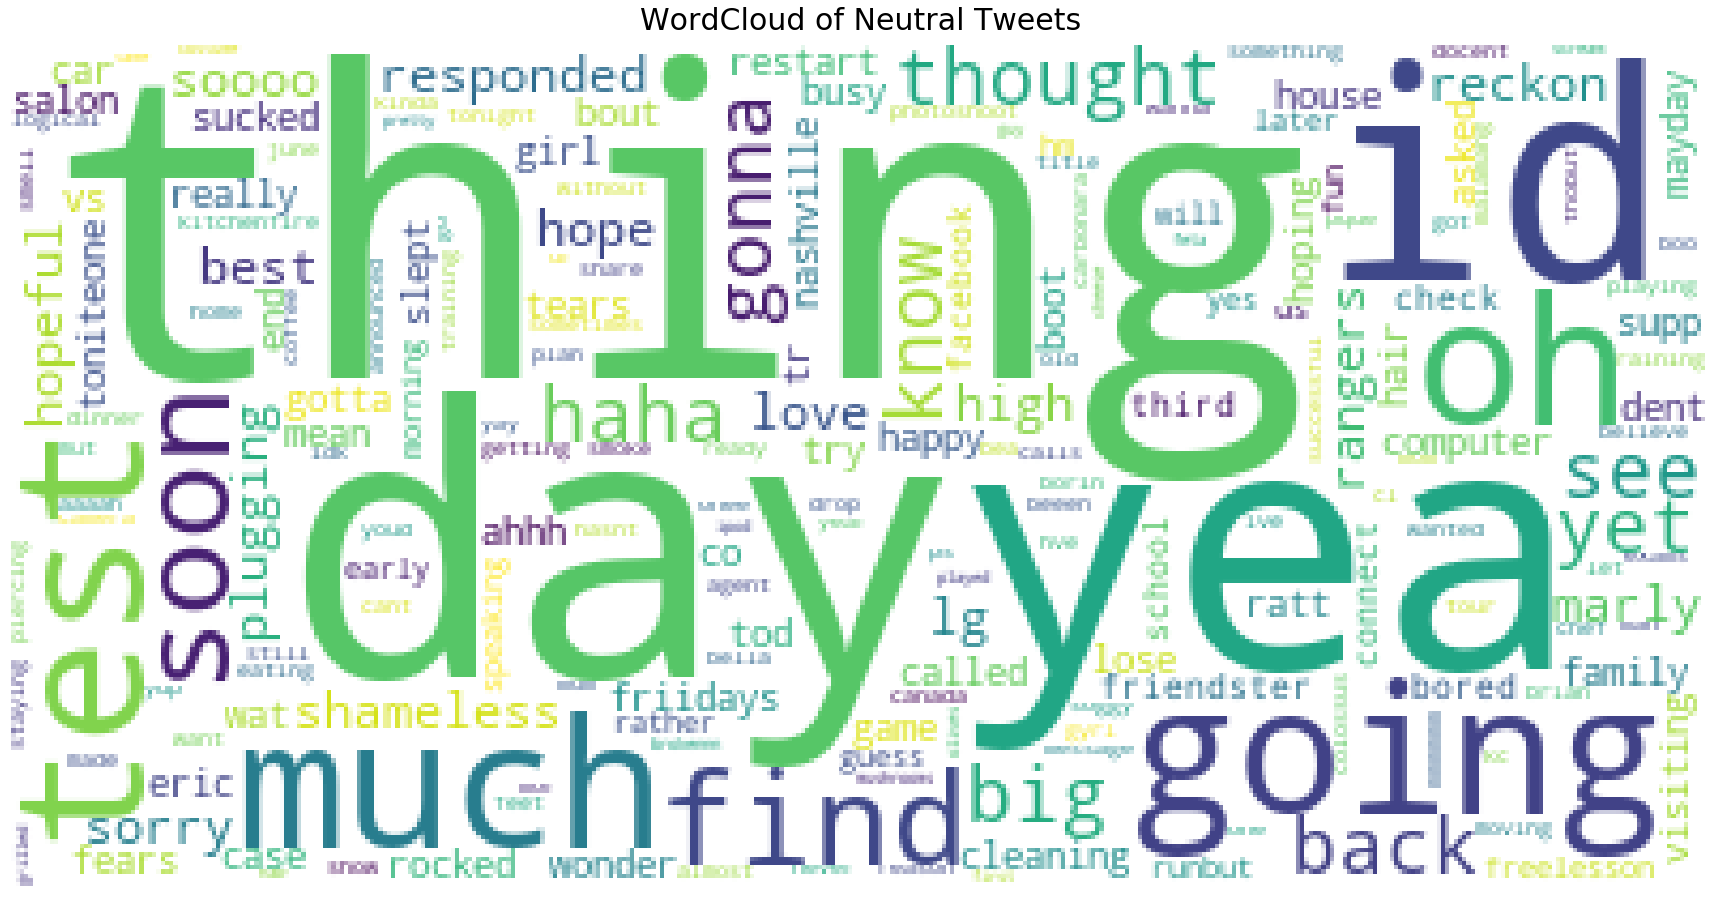

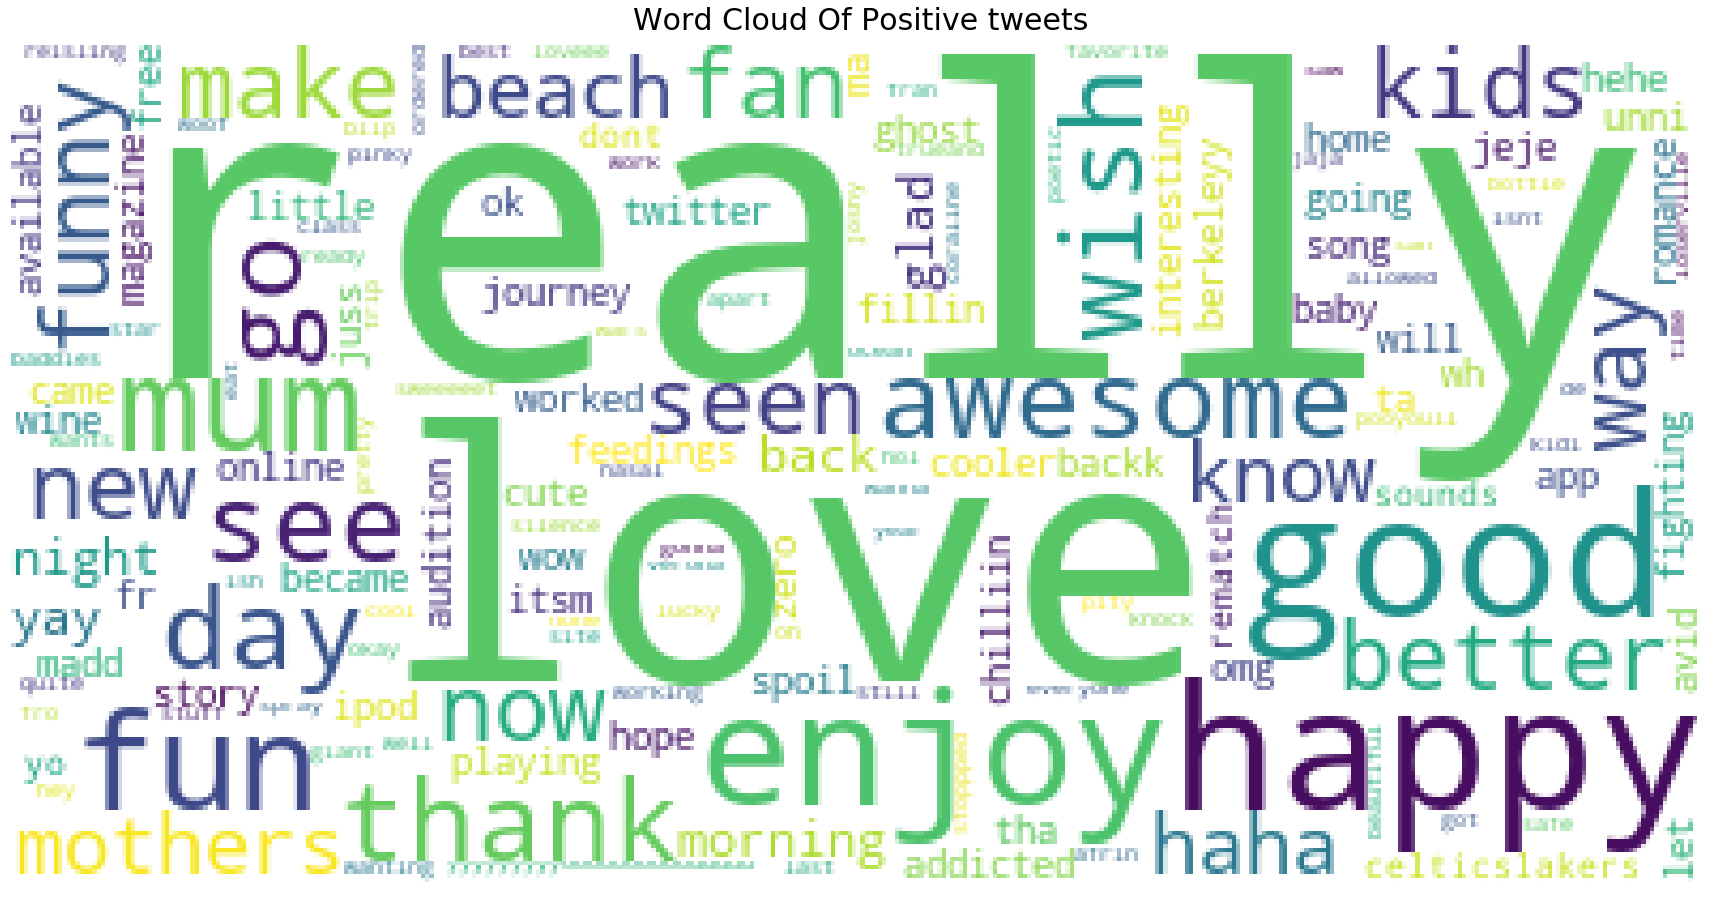

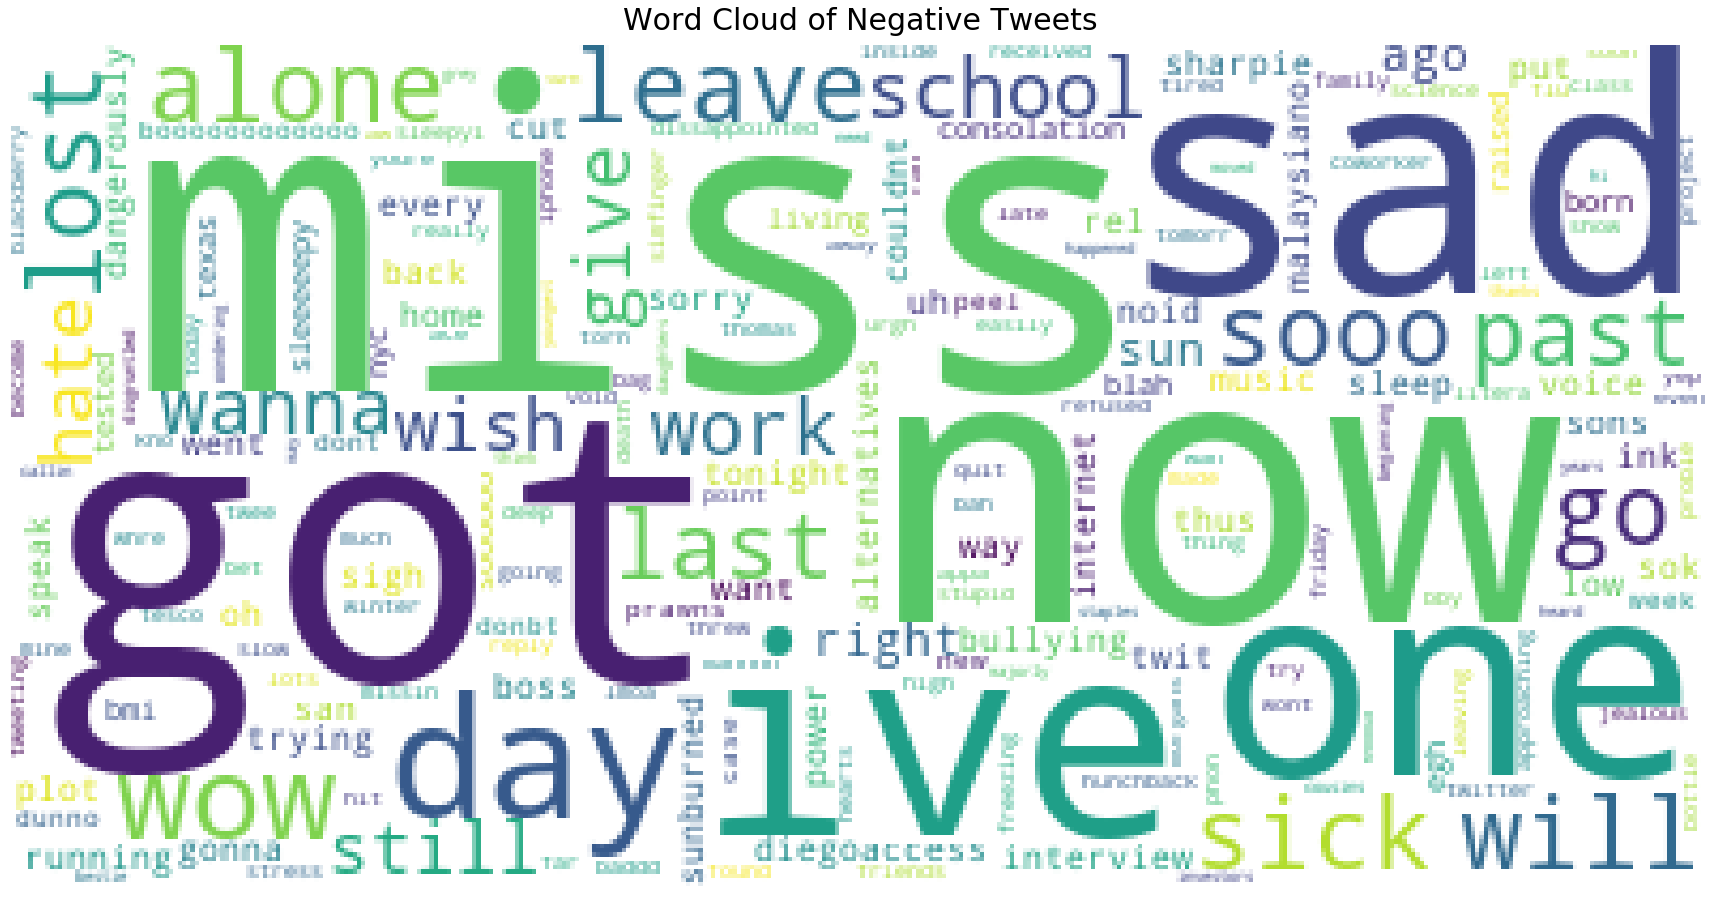

In [105]:
#%% wordcloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, 
                   figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(Neutral_sent.text,mask=None,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")   
# d = '/01 data/wordclouds/'    
# pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
# plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

# pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
# plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")
plot_wordcloud(Positive_sent.text,mask=None,title="Word Cloud Of Positive tweets",title_size=30)
plot_wordcloud(Negative_sent.text,mask=None,title="Word Cloud of Negative Tweets",color='white',title_size=30)

In [106]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,temp_list
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,"[sooo, sad]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,[bullying]
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2,"[leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11,[sons]


In [107]:
sents=[word_tokenize(sent) for sent in list(train.text.values)]
model = word2vec.Word2Vec(sents, sg=0, size=100,  window=5)
model.save('MyModel')

In [ ]:
hh
